<h1><center>SMS Spam Collection</center></h1>
<hr>

In [1]:
import pandas as pd
import numpy as np
import re
import os

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm

from tqdm import tqdm
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE


In [2]:
df = pd.read_csv('./raw_data/spam.csv', encoding = "ISO-8859-1")[['v1', 'v2']]
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
def binary_label(x):
    if x=='ham':
        return 0
    else:
        return 1
df['Label'] = df['v1'].map(binary_label)
df.head()

,v1,v2,Label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
#checking for ham text
df[df['Label']==0]['v2'].tail()

5565                                         Huh y lei...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, dtype: object

In [5]:
#checking for spam text
df[df['Label']==1]['v2'].tail()

5537    Want explicit SEX in 30 secs? Ring 02073162414...
5540    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547    Had your contract mobile 11 Mnths? Latest Moto...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
5567    This is the 2nd time we have tried 2 contact u...
Name: v2, dtype: object

# [2] Text Pre-processing

In [6]:
def deconcatinated(x):
    x = x.lower()
    x = re.sub(r"won\'t", "will not", x)
    x = re.sub(r"won\'t", "will not", x)
    x = re.sub(r"don\'t", "do not", x)
    x = re.sub(r"shouldn\'t", "should not", x)
    x = re.sub(r"couldtn\'t", "could not", x)
    x = re.sub(r"isn\'t", "is not", x)
    x = re.sub(r"\'ll", " will", x)
    x = re.sub(r"\'d", " would", x)
    x = re.sub(r"\'m", "i am", x)
    x = re.sub(r"&", " and ", x)
    return x


stop = stopwords.words('english')
stop.remove('not')

def remove_punctuation(x):
    x = re.sub(r"[!\"#$%()*+,.-/:;<=>?@^_`{|}~]", " ", x)
    x = re.sub(r"\s{2,}", " ", x)
    return x

In [7]:
filtered_text = list()
for line in tqdm(df['v2'].values):
    line = remove_punctuation(line)
    line = deconcatinated(line)
    filtered_line = list()
    for word in line.split():
        #if (word.lower() not in stop) and (word.lower().isalpha()):
        if (word.lower().isalnum()):
            filtered_line.append(word.lower())
    #print(filtered_line)
    filtered_text.append(' '.join(filtered_line))

#filtering the records with above logic.
df['filtered_text'] = filtered_text
df.head()

100%|███████████████████████████████████████████████████████████████████████████| 5572/5572 [00:00<00:00, 20572.73it/s]


,v1,v2,Label,filtered_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,0,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,0,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah i do not think he goes to usf he lives aro...


# [3] Word Cloud

In [8]:
#ham words
ham_text = list()
for line in df[df['Label']==0]['filtered_text']:
    ham_text.extend(line.split())

#spam words
spam_text = list()
for line in df[df['Label']==1]['filtered_text']:
    spam_text.extend(line.split())

#### Word Cloud of Ham Text

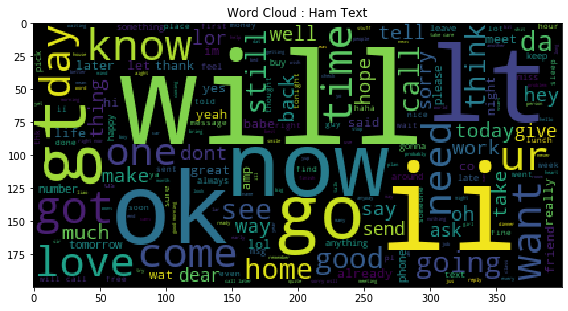

In [9]:
ham_wc = WordCloud().generate(' '.join(ham_text))

#plotting figure
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(ham_wc) 
plt.title('Word Cloud : Ham Text')
plt.tight_layout()

plt.show() 

#### Word Cloud Spam Text

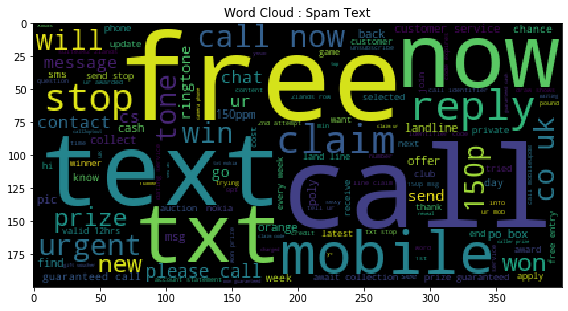

In [10]:
spam_wc = WordCloud().generate(' '.join(spam_text))

#plotting figure
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(spam_wc) 
plt.title('Word Cloud : Spam Text')
plt.tight_layout()
  
plt.show() 

# [4] Data Preparation

In [11]:
data = df[['filtered_text', 'Label']]
data.head()

,filtered_text,Label
0,go until jurong point crazy available only in ...,0
1,ok lar joking wif u oni,0
2,free entry in 2 a wkly comp to win fa cup fina...,1
3,u dun say so early hor u c already then say,0
4,nah i do not think he goes to usf he lives aro...,0


### [4.1] Text Length

In [12]:
def text_length(x):
    return len(x.split())

data['text_length'] = data['filtered_text'].map(text_length)
data.head()

C:\Users\kaushik\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,filtered_text,Label,text_length
0,go until jurong point crazy available only in ...,0,20
1,ok lar joking wif u oni,0,6
2,free entry in 2 a wkly comp to win fa cup fina...,1,30
3,u dun say so early hor u c already then say,0,11
4,nah i do not think he goes to usf he lives aro...,0,14


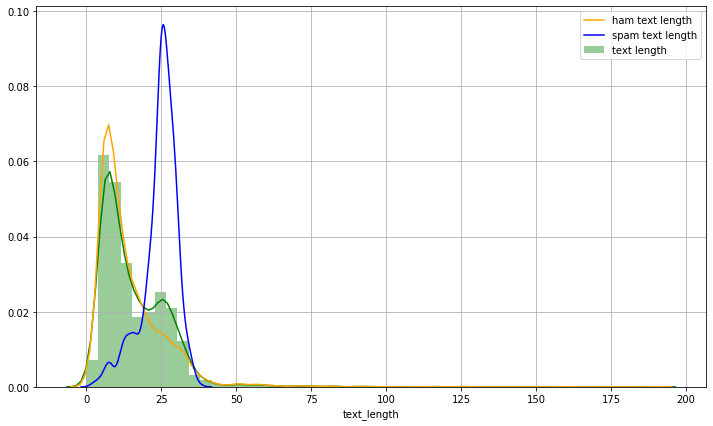

In [13]:
#checking distribution of text_length

plt.figure(figsize=(12, 7))
sns.distplot(data['text_length'], hist=True, label='text length', color='Green')
sns.distplot(data[data['Label']==0]['text_length'], hist=False, label='ham text length', color='orange')
sns.distplot(data[data['Label']==1]['text_length'], hist=False, label='spam text length', color='blue')
plt.grid()
plt.legend()
plt.show()

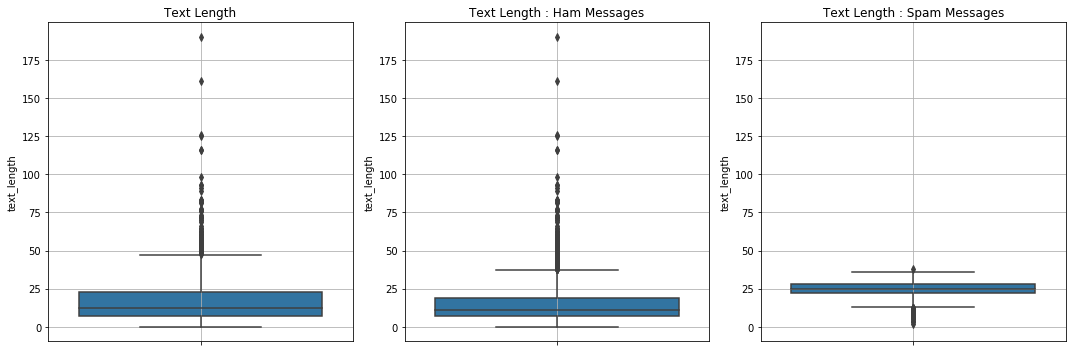

In [14]:
#plotting the box plot
plt.figure(figsize=(15, 5))

ax1=plt.subplot(131)
sns.boxplot(y=data['text_length'], ax=ax1)
ax1.set_title('Text Length')
ax1.grid()

ax2=plt.subplot(132, sharey=ax1)
sns.boxplot(y=data[data['Label']==0]['text_length'], ax=ax2)
ax2.set_title('Text Length : Ham Messages')
ax2.grid()

ax3=plt.subplot(133, sharey=ax2)
sns.boxplot(y=data[data['Label']==1]['text_length'], ax=ax3)
ax3.set_title('Text Length : Spam Messages')
ax3.grid()

plt.tight_layout()
plt.show()

<p>From histogram distribution of all texts, ham text and spam text, we can clearly see separation between histogram plots of ham and spam text lengths.</p>
<p>Ham text tend to be of shorter or longer length, depending on the user message. There are cases, where Ham text is high but they considered to be outliers.</p>
<p>Spam text on the other hand has specific length as seen from it's histogram as well as box-plot distribution.</p>

### [4.2] Presence of Digits

In [15]:
def text_digit(x):
    return len(re.findall(r'\d+', x))

data['presence_of_digit'] = data['filtered_text'].map(text_digit)
data.head()

,filtered_text,Label,text_length,presence_of_digit
0,go until jurong point crazy available only in ...,0,20,0
1,ok lar joking wif u oni,0,6,0
2,free entry in 2 a wkly comp to win fa cup fina...,1,30,4
3,u dun say so early hor u c already then say,0,11,0
4,nah i do not think he goes to usf he lives aro...,0,14,0


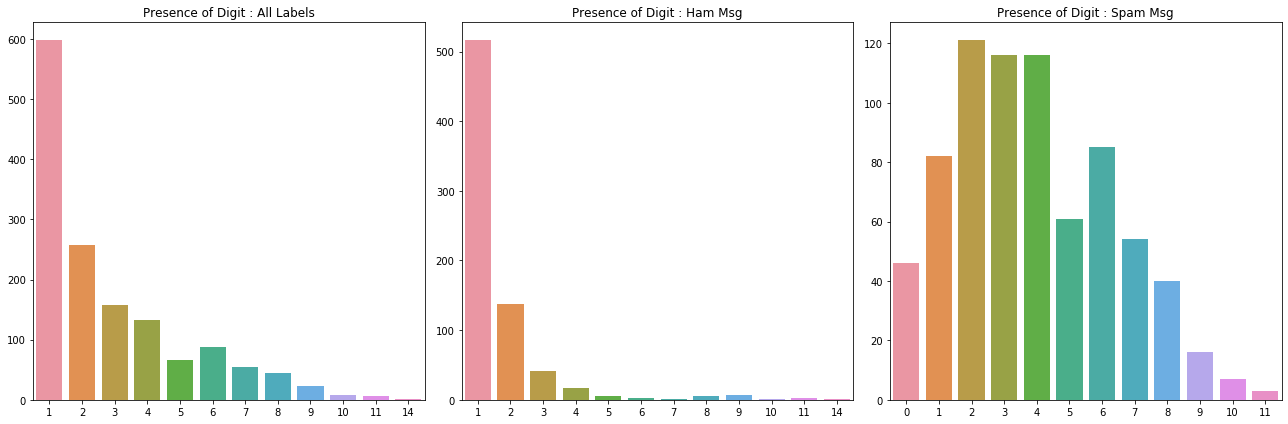

In [16]:
plt.figure(figsize=(18, 6))

ax1 = plt.subplot(131)
ax1.set_title('Presence of Digit : All Labels')
y = list(data['presence_of_digit'].value_counts().values[1:])
x = list(data['presence_of_digit'].value_counts().keys()[1:])
sns.barplot(x=x, y=y, ax=ax1)

ax2 = plt.subplot(132)
ax2.set_title('Presence of Digit : Ham Msg')
y = list(data[data['Label']==0]['presence_of_digit'].value_counts().values[1:])
x = list(data[data['Label']==0]['presence_of_digit'].value_counts().keys()[1:])
sns.barplot(x=x, y=y, ax=ax2)

ax3 = plt.subplot(133)
ax3.set_title('Presence of Digit : Spam Msg')
y = list(data[data['Label']==1]['presence_of_digit'].value_counts().values)
x = list(data[data['Label']==1]['presence_of_digit'].value_counts().keys())
sns.barplot(x=x, y=y, ax=ax3)

plt.tight_layout()
plt.show()

<p><b>Presence of digit : </b></p>
<p>for Ham messages, numeric apperence in messages is wither None or atleaset 1. There are very few cases where we see two or more numeric words present in Ham messages.</p>
<p>On the other hand, Spam messages contains two or more than 2 numerical words in messages which is more compared to that of Ham messages.</p>

In [17]:
data.head()

,filtered_text,Label,text_length,presence_of_digit
0,go until jurong point crazy available only in ...,0,20,0
1,ok lar joking wif u oni,0,6,0
2,free entry in 2 a wkly comp to win fa cup fina...,1,30,4
3,u dun say so early hor u c already then say,0,11,0
4,nah i do not think he goes to usf he lives aro...,0,14,0


In [18]:
data.to_csv('./sms_spam_collection_filtered.csv', index=False, encoding = "ISO-8859-1")

<hr>